In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clustering/clustering.py
/kaggle/input/preprocessing-train-test/preprocessing_train_test.py
/kaggle/input/preprocessing-merge/preprocessing_merge.py
/kaggle/input/cs5228-202223-s2-location-location-location/train.csv
/kaggle/input/cs5228-202223-s2-location-location-location/test.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-commerical-centres.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-gov-markets-hawker-centres.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-train-stations.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-population-demographics.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-shopping-malls.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-primary-schools.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-secondary-schools.csv
/kaggle/

In [21]:
import sys
sys.path.append("/kaggle/input/preprocessing-merge/")
sys.path.append("/kaggle/input/preprocessing-train-test/")
sys.path.append("/kaggle/input/clustering/")

from preprocessing_merge import *
from preprocessing_train_test import *
from clustering import *

In [3]:
%reload_ext autoreload
%autoreload 2

# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Helper function to plot training mae and mse across epochs later
def plot_error_epochs(history_results, metrics='mae'):

  plt.plot(history_results.history[metrics])
  plt.plot(history_results.history['val_'+metrics])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [5]:
# Helper function to plot training mae and mse across epochs later
def plot_error_epochs(history_results, metrics='mae'):

  plt.plot(history_results.history[metrics])
  plt.plot(history_results.history['val_'+metrics])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [6]:
def preprocess_mlp(train_df, test_df):

    # Perform shuffling of training data, so that batches can be more representative
    shuffled_training_df = train_df.sample(frac=1)

    X_train_shuffled = shuffled_training_df.loc[:, ~shuffled_training_df.columns.isin(["resale_price"])]
    y_train_shuffled = shuffled_training_df["resale_price"]
    y_test = test_df['resale_price']

    # Train a min-max scaler on the train dataset, and transform on both train and test
    sc = StandardScaler()
    sc_train = sc.fit(X_train_shuffled)
    X_train_scaled = sc_train.transform(X_train_shuffled)
    X_test_scaled = sc_train.transform(test_df[X_train_shuffled.columns])

    # Scale data down by 100,000 
    y_train_scaled = y_train_shuffled/100000
    y_test_scaled = y_test/100000

    # print("X_train shape: ", X_train_scaled.shape)
    # print("y_train shape: ", y_train_scaled.shape)
    # print("X_test shape: ", X_test_scaled.shape)
    # print("y_test shape: ", y_test_scaled.shape)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

In [5]:
def mlp_model(fold, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_layers_dict, initializer, \
              optimizer_set="Adam", input_neurons=20, activation_hidden='relu', activation_final='linear', learning_rate=0.01, \
              epochs=200, batch_size=24): 

    tf.keras.backend.clear_session() 

    # Build model architecture
    if initializer == "RandomUniform": 
        initializer_func = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed=42)
    elif initializer == "RandomNormal":
        initializer_func = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=42)
    elif initializer == "GlorotUniform": 
        initializer_func = tf.keras.initializers.GlorotUniform()
    elif initializer == "HeUniform":
        initializer_func = tf.keras.initializers.HeUniform()
    model = Sequential()
    model.add(Dense(input_neurons, input_dim=X_train_scaled.shape[1], activation='relu', kernel_initializer=initializer_func)) 
    for hidden_layer, hidden_neurons in hidden_layers_dict.items():
        model.add(Dense(hidden_neurons, activation=activation_hidden))
    model.add(Dense(1, activation=activation_final)) 

    # Compile model
    if optimizer_set == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
    elif optimizer_set == "SGD": 
        optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.8) 
    elif optimizer_set == "Adagrad":
        optimizer = tf.keras.optimizers.experimental.Adagrad(learning_rate=learning_rate) 
    elif optimizer_set == "RMSprop": 
        optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=learning_rate, momentum=0.8) 
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])

    # Fit model
    history = model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, \
                          validation_data=[X_test_scaled, y_test_scaled], callbacks=[es])
    display(history)

    # Save model
    model_name = "fold" + str(fold) + "_" + str(epochs) + "ep_" + str(batch_size) + "batches_" + str(learning_rate) \
                 + "rate_" + initializer + "_" + str(list(hidden_layers_dict.values())) + "_" + optimizer_set
    pickle.dump(model, \
              open(f'/kaggle/working/mlp_model_{model_name}.pkl', 'wb'))

    # Get predicted house price on training data
    yhat_train = 100000*model.predict(X_train_scaled)
    train_MAE = mean_absolute_error(y_train_scaled*100000, yhat_train)
    train_MSE = mean_squared_error(y_train_scaled*100000, yhat_train)

    # Get predicted house pricing on testing data
    yhat_test = 100000*model.predict(X_test_scaled)
    test_MAE = mean_absolute_error(y_test_scaled*100000, yhat_test)
    test_MSE = mean_squared_error(y_test_scaled*100000, yhat_test)

    return model, history, train_MAE, train_MSE, test_MAE, test_MSE


In [32]:
def single_run(data, param_dict, features_drop, model_path): 

    # Initialize score storing
    scores = {}

    # Data Preprocessing
    
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:, ~data.columns.isin(["resale_price"])], data["resale_price"], test_size=0.3, random_state=42)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    train_df, test_df = preprocess_train_test(train, test)
    train_df = train_df.loc[:, ~train_df.columns.isin(features_drop)]
    test_df = test_df.loc[:, ~test_df.columns.isin(features_drop)]
    print(train_df.columns)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_mlp(train_df, test_df)
    
    # Model Fitting
    hidden_layers_dict = param_dict["hidden_layers_dict"]
    initializer = param_dict["initializers"]
    optimizer_set = param_dict["optimizers"]
    learning_rate = param_dict["learning_rate"]
    epochs = param_dict["epochs"]
    batch_size = param_dict["batch_size"]
    model, history, train_mae, train_mse, valid_mae, valid_mse = mlp_model(0, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_layers_dict, initializer, \
        optimizer_set=optimizer_set, input_neurons=40, activation_hidden='relu', activation_final='linear', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size)
    
    # Save scores and models
    scores[(epochs, batch_size, learning_rate, initializer, optimizer_set, str(list(hidden_layers_dict.values())))] = (train_mae, valid_mae, train_mse, valid_mse)
    with open(f"/kaggle/working/{model_path}.pkl", "wb") as f: 
        pickle.dump(scores, f)

    return model, history, scores

In [23]:
dataset = pd.read_csv("/kaggle/input/preprocessed-data/merge_auxiliary_data_train.csv")
features_drop = ['distance_to_mrt_bins_price', 'mrt_lrt_links', 'population_bins_price', \
                 'adult_children_ratio_bins_price', 'mrt_interchange_flag', \
                 'mrt_interchange_count', 'mrt_type_price']
selected_columns = ['floor_area_sqm', 'distance_to_mrt', 'population_count', 'adult_count', 'children_count', \
                    'senior_citizen_count', 'teenager_count', 'female_count', 'male_count']

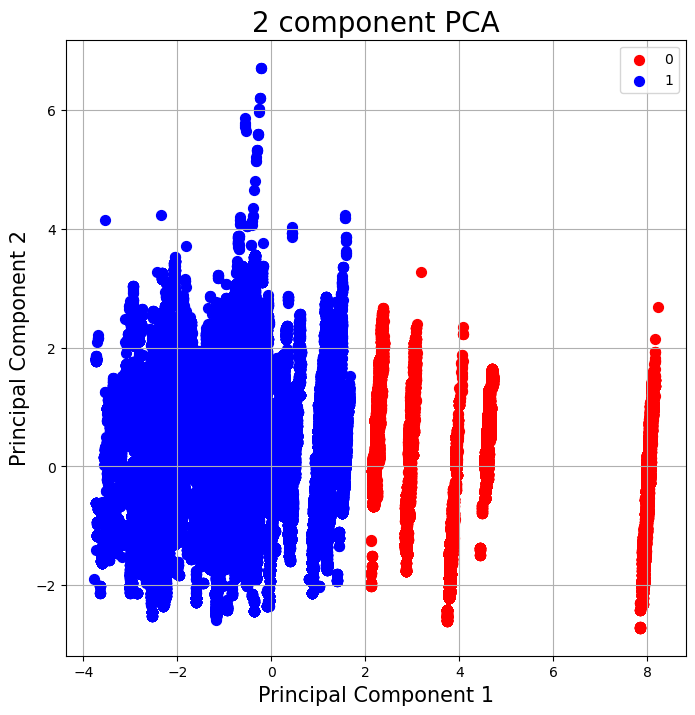

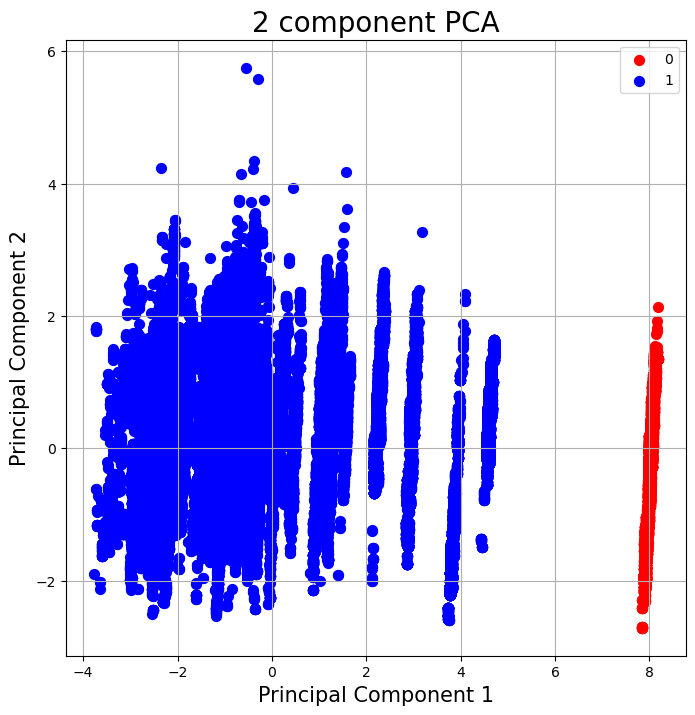

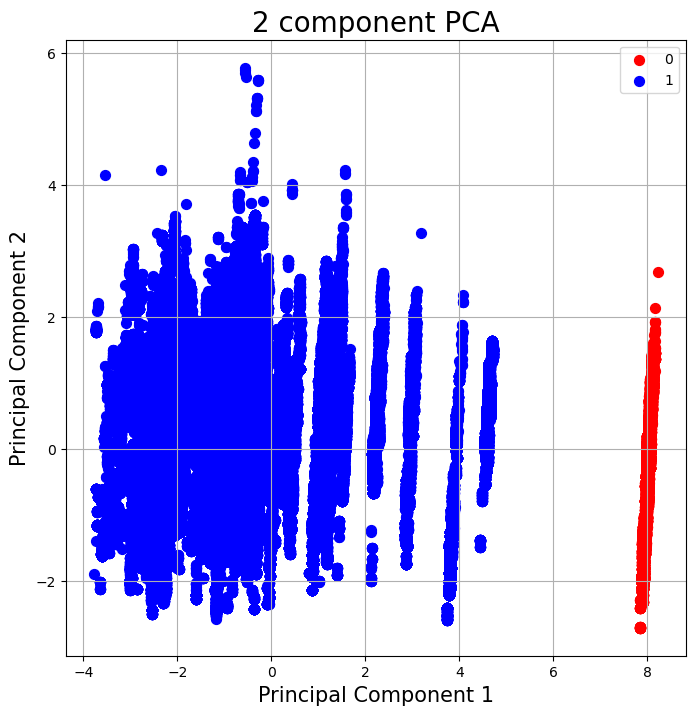

In [24]:
# Generate pca model, pca data for training
pca_train_data, pca_model_train = principal_component_analysis(dataset, selected_columns, plot=False)
kmeans_cluster_data, kmeans_model = kmeans_clustering(
    pca_train_data, k=2, plot=True)
sampled_data = sample_data(kmeans_cluster_data, perc_sample=0.1)
sample_dbscan, dbscan_model = dbscan_clustering(sampled_data, eps=1.5, min_samples=50, plot=True)
pca_clustering_train = dbscan_predict(dbscan_model=dbscan_model, data=pca_train_data)

In [10]:
# Load pre-run data for testing
pca_clustering_test = pd.read_csv("/kaggle/input/preprocessed-data/pca_clustering_testing.csv")

In [25]:
dataset_updated = pd.concat([dataset, pca_train_data.reset_index(drop=True)], axis=1)

In [26]:
dataset_updated.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,MinSecDist,nearSecondCount,mall_id,MinShopDist,nearShopCount,has_wikilink,principal component 1,principal component 2,resale_price,Kmeans_cluster
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,0.426133,4,68,1.028774,0,1,1.396698,1.219908,209700.0,1
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,0.311598,5,125,0.802249,4,0,0.320853,0.119832,402300.0,1
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,0.558057,1,127,0.450920,2,1,-0.358967,0.540133,351000.0,1
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,0.618757,2,154,0.454837,3,1,-1.143145,-1.440767,151200.0,1
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,0.218129,2,145,0.764629,1,1,-2.421644,-0.559862,318600.0,1


In [30]:
dataset_updated = dataset_updated.loc[:,~dataset_updated.columns.duplicated()].copy()

In [31]:
# Don't run this cell, Keep the snapshot of the output
hidden_layers_dict1 = {"hidden_layer1": 40, "hidden_layer2": 40}
param_dict = {"epochs": 100, \
              "batch_size": 64, \
              "learning_rate": 0.0001, \
              "initializers": "GlorotUniform",
              "hidden_layers_dict": hidden_layers_dict1, 
              "optimizers": "RMSprop"}
model, history, scores = single_run(dataset_updated, param_dict, features_drop, model_path="checkpoint_v1")

Index(['floor_area_sqm', 'latitude', 'longitude', 'distance_to_mrt',
       'nearest_mrt_counts', 'population_count', 'adult_count',
       'children_count', 'senior_citizen_count', 'teenager_count',
       'young_adult_count', 'female_count', 'male_count', 'male_female_ratio',
       'adult_children_ratio', 'nearest_dist_commerical',
       'inRangeCount_commerical', 'nearest_dist_market', 'inRangeCount_market',
       'primary_id', 'MinPrimaryDist', 'nearPrimaryCount', 'second_id',
       'MinSecDist', 'nearSecondCount', 'mall_id', 'MinShopDist',
       'nearShopCount', 'has_wikilink', 'principal component 1',
       'principal component 2', 'Kmeans_cluster', 'resale_price',
       'rebased_month', 'remaining_lease', '1-room', '2-room', '3-room',
       '4-room', '5-room', 'executive', 'multi-generation', 'flat_type_price',
       'flat_type_psm', 'flat_type_number', 'storey_range_start',
       'storey_range_processed', 'storey_range_price',
       'storey_range_price_psm', 'flat_mo

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-13 18:54:09         2665
variables.h5                                   2023-04-13 18:54:09        75776
metada

In [33]:
hidden_layers_dict1 = {"hidden_layer1": 40, "hidden_layer2": 40}
param_dict = {"epochs": 150, \
              "batch_size": 64, \
              "learning_rate": 0.0001, \
              "initializers": "GlorotUniform",
              "hidden_layers_dict": hidden_layers_dict1, 
              "optimizers": "RMSprop"}
model_v2, history_v2, scores_v2 = single_run(dataset_updated, param_dict, features_drop, model_path="checkpoint_v2")

Index(['floor_area_sqm', 'latitude', 'longitude', 'distance_to_mrt',
       'nearest_mrt_counts', 'population_count', 'adult_count',
       'children_count', 'senior_citizen_count', 'teenager_count',
       'young_adult_count', 'female_count', 'male_count', 'male_female_ratio',
       'adult_children_ratio', 'nearest_dist_commerical',
       'inRangeCount_commerical', 'nearest_dist_market', 'inRangeCount_market',
       'primary_id', 'MinPrimaryDist', 'nearPrimaryCount', 'second_id',
       'MinSecDist', 'nearSecondCount', 'mall_id', 'MinShopDist',
       'nearShopCount', 'has_wikilink', 'principal component 1',
       'principal component 2', 'Kmeans_cluster', 'resale_price',
       'rebased_month', 'remaining_lease', '1-room', '2-room', '3-room',
       '4-room', '5-room', 'executive', 'multi-generation', 'flat_type_price',
       'flat_type_psm', 'flat_type_number', 'storey_range_start',
       'storey_range_processed', 'storey_range_price',
       'storey_range_price_psm', 'flat_mo

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-13 19:32:32         2665
variables.h5                                   2023-04-13 19:32:32       100256
metada

In [34]:
# Don't run this cell, Keep the snapshot of the output
hidden_layers_dict1 = {"hidden_layer1": 40, "hidden_layer2": 40}
param_dict = {"epochs": 200, \
              "batch_size": 64, \
              "learning_rate": 0.0001, \
              "initializers": "GlorotUniform",
              "hidden_layers_dict": hidden_layers_dict1, 
              "optimizers": "RMSprop"}
model_v3, history_v3, scores_v3 = single_run(dataset_updated, param_dict, features_drop, model_path="checkpoint_v3")

Index(['floor_area_sqm', 'latitude', 'longitude', 'distance_to_mrt',
       'nearest_mrt_counts', 'population_count', 'adult_count',
       'children_count', 'senior_citizen_count', 'teenager_count',
       'young_adult_count', 'female_count', 'male_count', 'male_female_ratio',
       'adult_children_ratio', 'nearest_dist_commerical',
       'inRangeCount_commerical', 'nearest_dist_market', 'inRangeCount_market',
       'primary_id', 'MinPrimaryDist', 'nearPrimaryCount', 'second_id',
       'MinSecDist', 'nearSecondCount', 'mall_id', 'MinShopDist',
       'nearShopCount', 'has_wikilink', 'principal component 1',
       'principal component 2', 'Kmeans_cluster', 'resale_price',
       'rebased_month', 'remaining_lease', '1-room', '2-room', '3-room',
       '4-room', '5-room', 'executive', 'multi-generation', 'flat_type_price',
       'flat_type_psm', 'flat_type_number', 'storey_range_start',
       'storey_range_processed', 'storey_range_price',
       'storey_range_price_psm', 'flat_mo

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-13 20:25:52         2665
variables.h5                                   2023-04-13 20:25:52       100256
metada

In [35]:
# Don't run this cell, Keep the snapshot of the output
hidden_layers_dict1 = {"hidden_layer1": 60, "hidden_layer2": 60}
param_dict = {"epochs": 200, \
              "batch_size": 64, \
              "learning_rate": 0.0005, \
              "initializers": "GlorotUniform",
              "hidden_layers_dict": hidden_layers_dict1, 
              "optimizers": "RMSprop"}
model_v4, history_v4, scores_v4 = single_run(dataset_updated, param_dict, features_drop, model_path="checkpoint_v4")

Index(['floor_area_sqm', 'latitude', 'longitude', 'distance_to_mrt',
       'nearest_mrt_counts', 'population_count', 'adult_count',
       'children_count', 'senior_citizen_count', 'teenager_count',
       'young_adult_count', 'female_count', 'male_count', 'male_female_ratio',
       'adult_children_ratio', 'nearest_dist_commerical',
       'inRangeCount_commerical', 'nearest_dist_market', 'inRangeCount_market',
       'primary_id', 'MinPrimaryDist', 'nearPrimaryCount', 'second_id',
       'MinSecDist', 'nearSecondCount', 'mall_id', 'MinShopDist',
       'nearShopCount', 'has_wikilink', 'principal component 1',
       'principal component 2', 'Kmeans_cluster', 'resale_price',
       'rebased_month', 'remaining_lease', '1-room', '2-room', '3-room',
       '4-room', '5-room', 'executive', 'multi-generation', 'flat_type_price',
       'flat_type_psm', 'flat_type_number', 'storey_range_start',
       'storey_range_processed', 'storey_range_price',
       'storey_range_price_psm', 'flat_mo

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-13 21:14:36         2665
variables.h5                                   2023-04-13 21:14:36       135480
metada

# Evaluation

In [ ]:
hidden_layers_dict1 = {"hidden_layer1": 40, "hidden_layer2": 40}
param_dict = {"epochs": 150, \
              "batch_size": 64, \
              "learning_rate": 0.0001, \
              "initializers": "GlorotUniform",
              "hidden_layers_dict": hidden_layers_dict1, 
              "optimizers": "RMSprop"}
model_v2, history_v2, scores_v2 = single_run(dataset_updated, param_dict, features_drop, model_path="checkpoint_v2")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_updated.loc[:, ~dataset_updated.columns.isin(["resale_price"])], dataset_updated["resale_price"], test_size=0.3, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train_df, test_df = preprocess_train_test(train, test)
train_df = train_df.loc[:, ~train_df.columns.isin(features_drop)]
test_df = test_df.loc[:, ~test_df.columns.isin(features_drop)]
print(train_df.columns)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = preprocess_mlp(train_df, test_df)

In [ ]:
# Get predicted house price on training data
yhat_train = 100000*model_v2.predict(X_train_scaled)

# MLP: Training MSE and MAE
print('Training MSE::: %.3f' % mean_squared_error(y_train_scaled*100000, yhat_train))
print('Training MAE::: %.3f' % mean_absolute_error(y_train_scaled*100000, yhat_train))

In [ ]:
# Get predicted house price on training data
yhat_test = 100000*model_v2.predict(X_test_scaled)

# MLP: Training MSE and MAE
print('Training MSE::: %.3f' % mean_squared_error(y_test_scaled*100000, yhat_test))
print('Training MAE::: %.3f' % mean_absolute_error(y_test_scaled*100000, yhat_test))

In [ ]:
# Plot training and testing error vs. epochs curve
plot_error_epochs(history_v2, metrics='mae')
plot_error_epochs(history_v2, metrics='mse')